In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: 
                f.write(chunk)

download_file_from_google_drive('14Gh62sEIynvrhuNzxweHoz2if_ABuZaI', '/tmp/multiclass_flowers_64.npz')

In [ ]:
with np.load('/tmp/multiclass_flowers_64.npz') as data:
    X_train, Y_train, X_validation, Y_validation = [ data[key] for key in ['X_train', 'y_train', 'X_test', 'y_test'] ]

X_train.shape = (X_train.shape[0], np.product( X_train.shape[1:]))
X_train = X_train.T
X_validation.shape = (X_validation.shape[0], np.product( X_validation.shape[1:]))
X_validation = X_validation.T

classes = np.unique(Y_train)
num_classes = len(classes)
print('{} training and {} test samples loaded.'.format(Y_train.size, Y_validation.size))
print('Number of classes: ', num_classes)

450 training and 50 test samples loaded.
Number of classes:  5


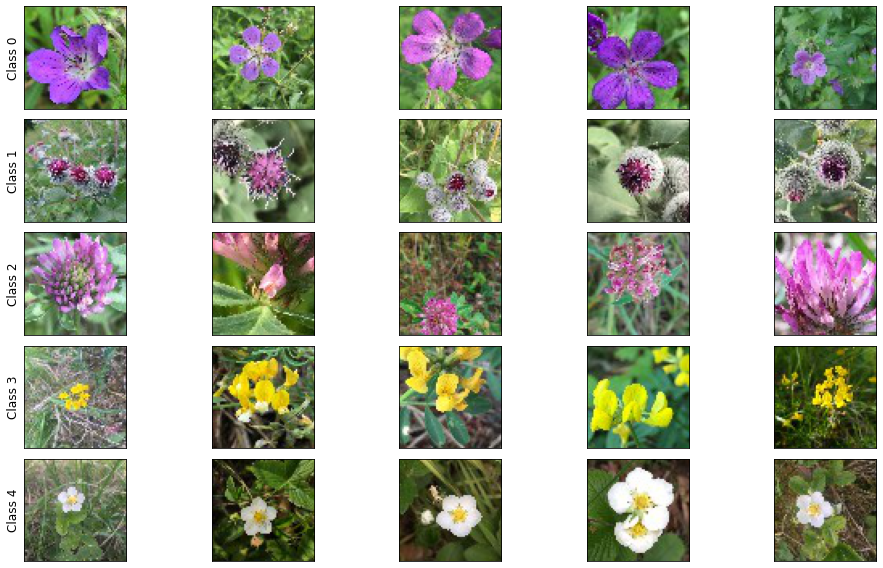

In [ ]:
fig, ax = plt.subplots(nrows=num_classes, ncols=5, sharex=True, sharey=True,)
fig.set_size_inches(14, 8)
ax = ax.flatten()
for class_ in range(num_classes):
  ax[num_classes*class_].set_ylabel('Class {}'.format(class_), rotation=90, size='large')
  for sample_ in range(5):
    img = X_train[:, Y_train == class_][:,sample_].reshape(64,64,3) + .5
    ax[num_classes*class_ + sample_].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[num_classes*class_ + sample_].imshow(img)
plt.tight_layout()
plt.show()

**450 Training examples**


In [ ]:
X_train.shape

(12288, 450)

In [ ]:
Y_train.shape

(450,)

In [ ]:
print(Y_train[:10])

[3 0 2 2 3 3 3 3 1 4]


In [ ]:
len(Y_train)

450

In [ ]:
def onehot(y, n_classes):
  max = np.max(y) + 1
  y_onehot = (np.eye(max)[y]).T

  return y_onehot

In [ ]:
print( onehot(Y_train[:10], 5) )

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
def predict_multiclass(A_out):
  y_prediction = np.argmax(A_out,axis=0)

  return y_prediction

In [ ]:
print( predict_multiclass(np.array([[ 0,  0, .8, .7, .1], 
                                    [.9, .2,  0, .2, .6], 
                                    [.1, .8, .2, .1, .3]])))

[1 2 0 0 1]


In [ ]:
def softmax(Z):
  S=np.exp(Z)/np.exp(Z).sum(axis=0, keepdims=True)

  return S

In [ ]:
print(softmax( np.array([[-3.3,  3.57,  0.9],
                         [-0.3,  0.96,  1.4],
                         [-0.2,  1.40,  1.7],
                         [ 2.5, -4.63, -1.9],
                         [-0.2, -0.82, -3.0]]) ).sum(axis=0))

[1. 1. 1.]


In [ ]:
def cross_entropy_loss(Y, Y_hat):
  Y_hat += 1e-9
  loss = np.mean(-Y * np.log(Y_hat) - (1 - Y) * np.log(1 - Y_hat))
  dY_hat = (Y_hat - Y) / (Y_hat * (1 - Y_hat))

  return loss, dY_hat

## Dense FCN Layer 

In [ ]:
class Dense:

  def __init__(self, neurons, input_shape):

    self.input_shape = input_shape
    self.neurons = neurons
    self.W = np.random.randn(self.neurons, self.input_shape[0]) * np.sqrt(2/(self.input_shape[0]+self.neurons))
    self.b = np.zeros( (self.neurons, 1) )
    self.Z_out = np.zeros( (self.neurons, self.input_shape[1]))


  def forward(self, A_in):
    self.A_in = A_in 
    self.Z_out = np.matmul(self.W, self.A_in) + self.b


  def backward(self, gradient):
    self.dW = np.dot(gradient, self.A_in.T)
    self.db = np.sum(gradient, axis=1, keepdims=True)
    self.dA_in = np.dot(self.W.T, gradient)


  def update(self, learning_rate):
    self.W -= self.dW * LEARNING_RATE
    self.b -= self.db * LEARNING_RATE

In [ ]:
class Sigmoid:
  def __init__(self, input_shape):
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    self.A_out = np.reciprocal(1 + np.exp(-Z_in))

  def backward(self, gradient):
    self.dZ = gradient * self.A_out*(1 - self.A_out)

In [ ]:
class Softmax:
  def __init__(self, input_shape):
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    Z_in -= np.max(Z_in)
    self.A_out = softmax(Z_in)

  def backward(self, gradient):
    t1 = np.einsum('ji,ki->ijk', self.A_out, self.A_out)
    t2 = np.einsum('ji,kj->ijk', self.A_out, np.eye(self.A_out.shape[0], self.A_out.shape[0]))
    dS = t2-t1
    self.dZ = np.einsum('ijk,ki->ji', dS, gradient)

In [ ]:
def lr_inverse_decay(lr0, epoch, decay=.01):
  lr = lr0/(1+decay*epoch)
  return lr

In [ ]:
def lr_step_decay(lr0, epoch, drop=.9, drop_epochs=10):
  return lr0 * np.power(drop, np.floor(epoch/drop_epochs))

In [ ]:
def lr_exponential_decay(lr0, epoch, decay=.01):
  lr = lr0*np.exp(-decay*epoch)
  return lr

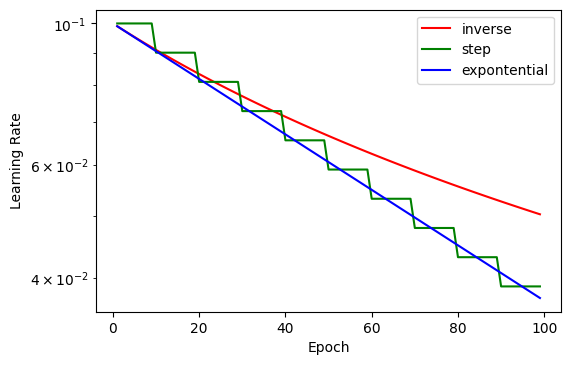

In [ ]:
lr0 = 1e-1
epochs=np.arange(1,100, 1)

plt.figure(dpi=100)
plt.plot(epochs, lr_inverse_decay(lr0, epochs), 
         color='red', label='inverse')
plt.plot(epochs, lr_step_decay(lr0, epochs), 
         color='green', label='step')
plt.plot(epochs, lr_exponential_decay(lr0, epochs), 
         color='blue', label='expontential')
plt.legend()
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

In [ ]:
BATCHSIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
NUM_CLASSES = len(np.unique(Y_train))

In [ ]:
my_NN = NeuralNet(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_step_decay,
                  )

Initialized Neural Network with 122945 parameters.


In [ ]:
history = my_NN.fit(X_train, Y_train,
                    X_validation, Y_validation, 
                    NUM_EPOCHS
                    )

Progress: 100/100 | Loss: 0.023 | validation loss: 0.19 | train accuracy: 88.86% | validation accuracy: 76.00% learning rate: 3.87e-04

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 76.0%


In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history['loss'], label='training')
  ax1.plot(history['val_loss'], label='validation', linestyle='--')
  ax1.set_ylabel('Binary CE Loss')
  ax1b = ax1.twinx()
  ax1b.plot(history['learning_rate'], 'g-', linewidth=1)
  ax1b.set_yscale('log')
  ax1b.set_ylabel('Learning Rate', color='g')
  
  ax2.plot(history['train_acc'], label='training')
  ax2.plot(history['val_acc'], label='validation', linestyle='--')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

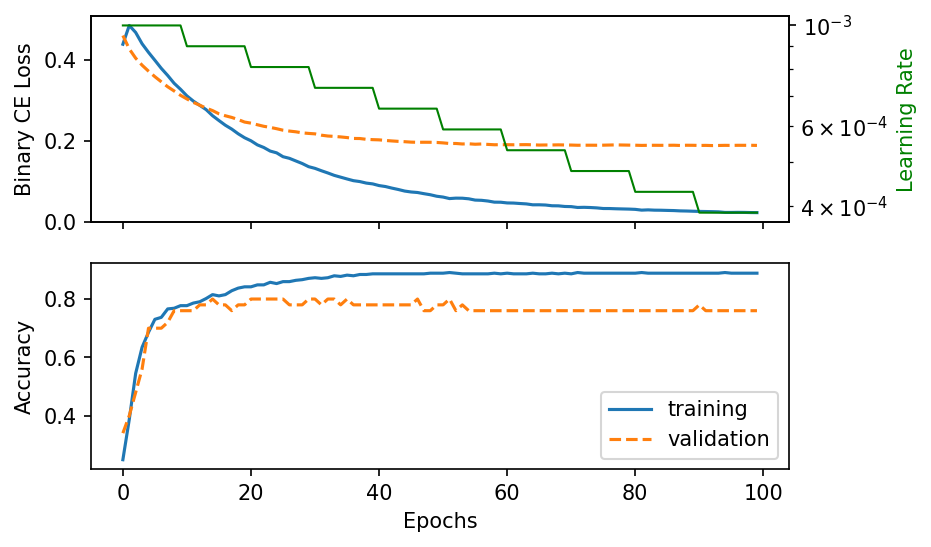

In [ ]:
plot_history(history)

Learning rate schedule: constant
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_step_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_inverse_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_exponential_decay
run 0

run 1

run 2

run 3

run 4



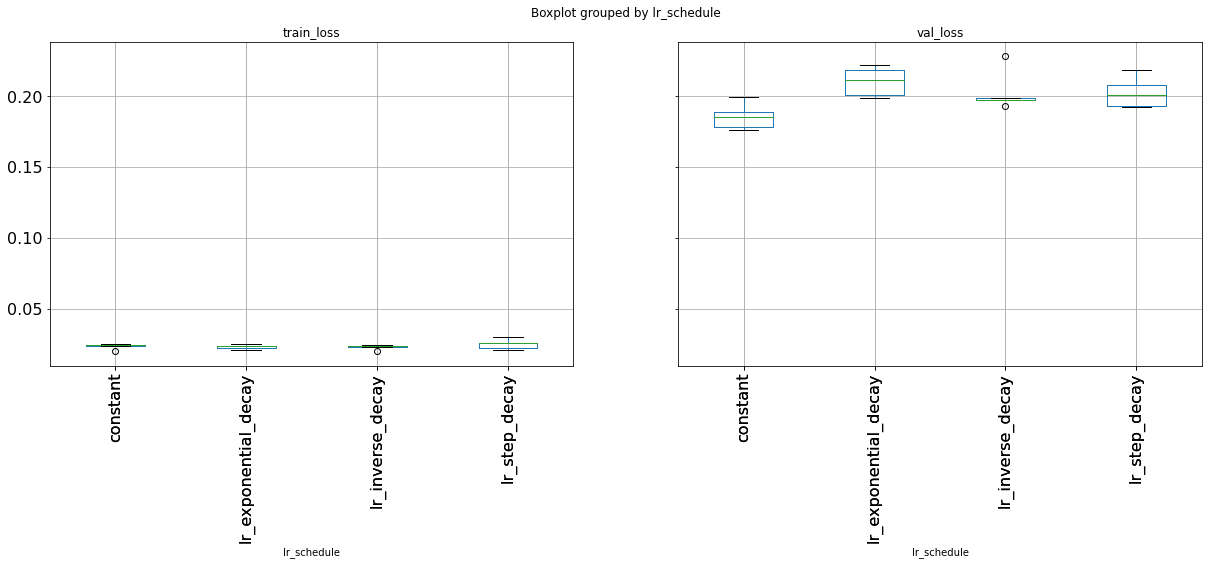

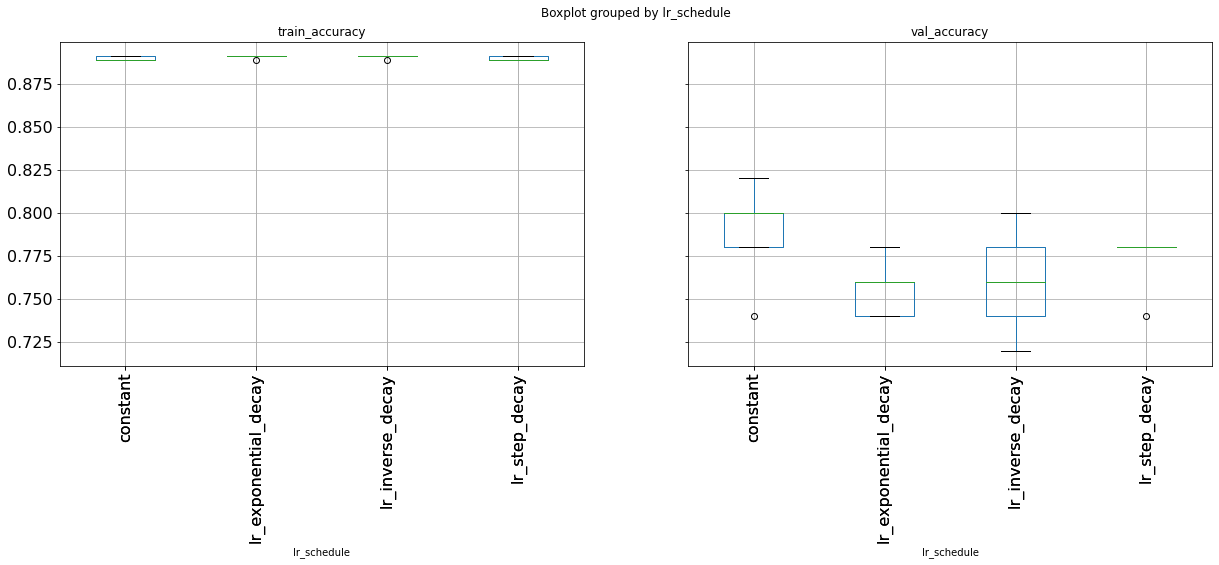

In [ ]:
import pandas as pd

results = pd.DataFrame(columns=['lr_schedule', 'repetition', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for lr_schedule in (None, lr_step_decay, lr_inverse_decay, lr_exponential_decay):
  print('Learning rate schedule:', lr_schedule.__name__ if lr_schedule else 'constant')
  for repetition in range(5):
    print('run', repetition)
    my_NN = NeuralNet(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_schedule,
                  verbose=False
                  )
    history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)
    run_results = [lr_schedule.__name__ if lr_schedule else 'constant', 
                   repetition,
                   history['loss'][-1],
                   history['val_loss'][-1],
                   history['train_acc'][-1],
                   history['val_acc'][-1],
                   ]
    results.loc[len(results)] = run_results

axes = results.boxplot(column=['train_loss', 'val_loss'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

axes = results.boxplot(column=['train_accuracy', 'val_accuracy'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

# Increasing the Networks Depth

In [ ]:
class DeepNeuralNet(NeuralNet):

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    self.Z1 = Dense(10,
                    (self.input_shape[0], self.batch_size))
    self.A1 = Sigmoid(self.Z1.Z_out.shape)

    self.Z2 = Dense(10,self.A1.A_out.shape)
    self.A2 = Sigmoid(self.Z2.Z_out.shape)

    self.Z3 = Dense(10,self.A2.A_out.shape)
    self.A3 = Sigmoid(self.Z3.Z_out.shape)

    self.Z4 = Dense(5,
                    self.A3.A_out.shape)
    self.A4 = Softmax(self.Z4.Z_out.shape)

  def _forward(self, X):
    self.Z1.forward(X)
    self.A1.forward(self.Z1.Z_out)
    self.Z2.forward(self.A1.A_out)
    self.A2.forward(self.Z2.Z_out)
    self.Z3.forward(self.A2.A_out)
    self.A3.forward(self.Z3.Z_out)
    self.Z4.forward(self.A3.A_out)
    self.A4.forward(self.Z4.Z_out)
    return self.A4.A_out

  def _backprop(self, dA_out):
    self.A4.backward(dA_out)
    self.Z4.backward(self.A4.dZ)
    self.A3.backward(self.Z4.dA_in)
    self.Z3.backward(self.A3.dZ)    
    self.A2.backward(self.Z3.dA_in)
    self.Z2.backward(self.A2.dZ)
    self.A1.backward(self.Z2.dA_in)
    self.Z1.backward(self.A1.dZ)    

  def _update(self, learning_rate):
    self.Z4.update(learning_rate)
    self.Z3.update(learning_rate)
    self.Z2.update(learning_rate)
    self.Z1.update(learning_rate)

Initialized Neural Network with 123165 parameters.



Progress: 100/100 | Loss: 0.5 | validation loss: 0.44 | train accuracy: 49.22% | validation accuracy: 60.00% learning rate: 3.87e-04

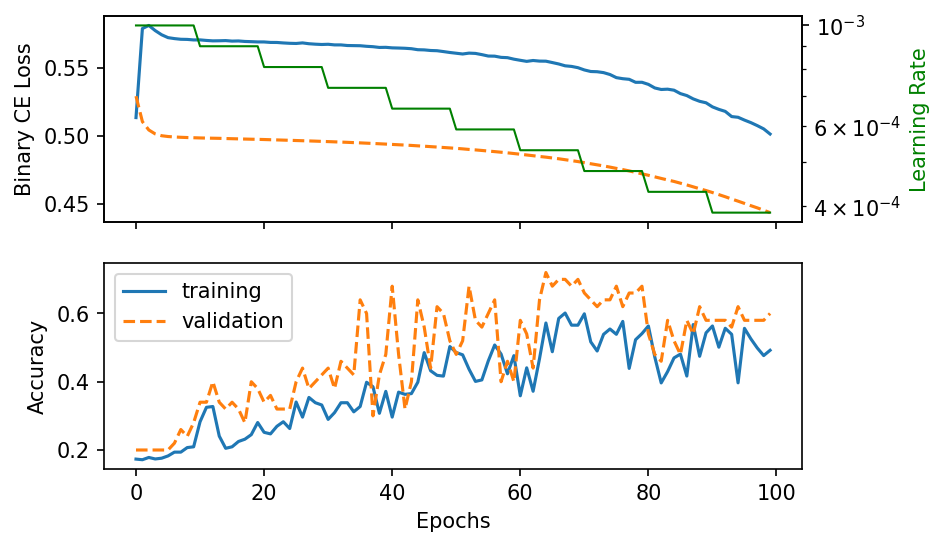

In [ ]:
my_DNN = DeepNeuralNet(X_train.shape,
                       5,
                       batch_size=BATCHSIZE,
                       init_lr=LEARNING_RATE,
                       lr_scheduler=lr_step_decay,
                       )

history = my_DNN.fit(X_train, Y_train,
                     X_validation, Y_validation, 
                     NUM_EPOCHS
                     )

plot_history(history)

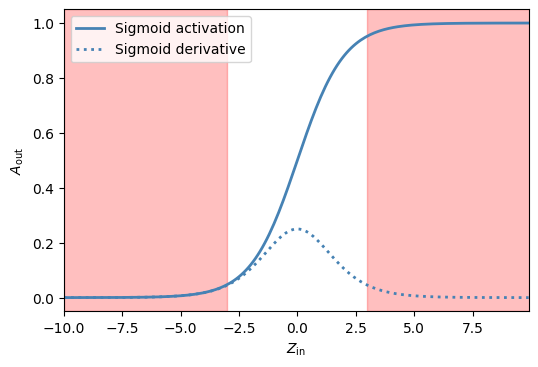

In [ ]:
z_in = np.arange(-10, 10, .1)
_sigmoid = Sigmoid(z_in.shape)
_sigmoid.forward(z_in)
_sigmoid.backward(1)
plt.figure(dpi=100)
plt.plot(z_in, _sigmoid.A_out, 
         color='steelblue', 
         linewidth=2,
         label='Sigmoid activation'
         )
plt.plot(z_in, _sigmoid.dZ, 
         color='steelblue', 
         linewidth=2,
         linestyle=':',
         label='Sigmoid derivative'
         )
plt.axvspan(-10, -3, color='red', alpha=0.25)
plt.axvspan(3, 10, color='red', alpha=0.25)
plt.xlim((np.min(z_in), np.max(z_in)))
plt.xlabel(r'$Z_\mathrm{in}$')
plt.ylabel(r'$A_\mathrm{out}$')
plt.legend()
plt.show()

In [ ]:
class ReLU:

  def __init__(self, input_shape):
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    self.Z_in = Z_in
    self.A_out = np.maximum(0,self.Z_in)

  def backward(self, gradient):
    relugrad = self.Z_in > 0
    self.dZ = gradient*relugrad

In [ ]:
class Swish:

  def __init__(self, input_shape, beta=1.):
    self.A_out = np.zeros( input_shape )
    self._beta = beta

  def forward(self, Z_in):
    self.Z_in = Z_in
    self.A_out = self.Z_in/(1+np.exp(-self._beta*self.Z_in))

  def backward(self, gradient):
    self.dZ = gradient * ( self._beta * self.A_out + 1/(1+np.exp(-self._beta * self.Z_in)) * (1 - self._beta * self.A_out))

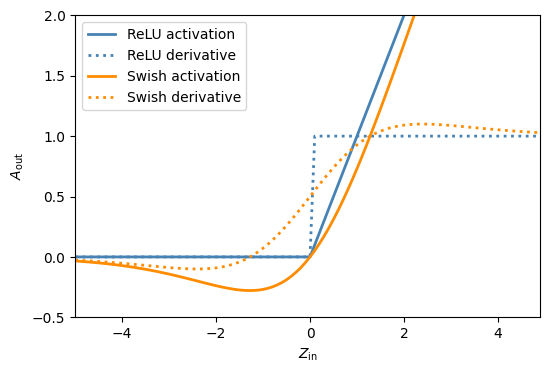

In [ ]:
z_in = np.arange(-5, 5, .1)
_relu = ReLU(z_in.shape)
_relu.forward(z_in)
_relu.backward(1)
_swish = Swish(z_in.shape)
_swish.forward(z_in)
_swish.backward(1)
plt.figure(dpi=100)
plt.plot(z_in, _relu.A_out, 
         color='steelblue',
         linewidth=2,
         label='ReLU activation'
         )
plt.plot(z_in, _relu.dZ, 
         color='steelblue',
         linewidth=2,
         linestyle=':',
         label='ReLU derivative'
         )
plt.plot(z_in, _swish.A_out, 
         color='darkorange',
         linewidth=2, 
         label='Swish activation'
         )
plt.plot(z_in, _swish.dZ, 
         color='darkorange',
         linewidth=2,
         linestyle=':',
         label='Swish derivative'
         )
plt.xlim((np.min(z_in), np.max(z_in)))
plt.ylim((-.5, 2))
plt.xlabel(r'$Z_\mathrm{in}$')
plt.ylabel(r'$A_\mathrm{out}$')
plt.legend()
plt.show()

In [ ]:
class DeepNeuralNet_Swish(DeepNeuralNet):

  def __init__(self,*args, **kwargs):
    super().__init__(*args, **kwargs)

  def set_architecture(self):
    self.Z1 = Dense(10,
                    (self.input_shape[0], self.batch_size))
    self.A1 = Swish(self.Z1.Z_out.shape)

    self.Z2 = Dense(10, 
                    self.A1.A_out.shape)
    self.A2 = Swish(self.Z2.Z_out.shape)

    self.Z3 = Dense(10, 
                    self.A2.A_out.shape)
    self.A3 = Swish(self.Z3.Z_out.shape)

    self.Z4 = Dense(num_classes, 
                    self.A3.A_out.shape)
    self.A4 = Softmax(self.Z4.Z_out.shape)

Initialized Neural Network with 123165 parameters.



Progress: 18/100 | Loss: 0.036 | validation loss: 0.23 | train accuracy: 87.53% | validation accuracy: 72.00% learning rate: 9.00e-04/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log
Progress: 100/100 | Loss: nan | validation loss: nan | train accuracy: 89.09% | validation accuracy: 74.00% learning rate: 3.87e-04

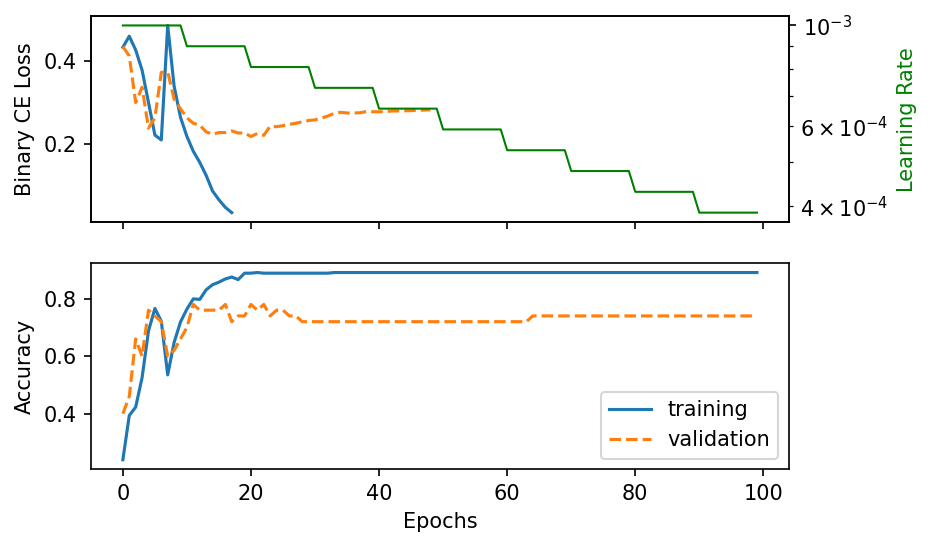

In [ ]:
my_DNN = DeepNeuralNet_Swish(X_train.shape,
                             NUM_CLASSES,
                             batch_size=BATCHSIZE,
                             init_lr=LEARNING_RATE,
                             lr_scheduler=lr_step_decay,
                             )

history = my_DNN.fit(X_train, Y_train,
                     X_validation, Y_validation, 
                     NUM_EPOCHS
                     )

plot_history(history)

Learning rate schedule: constant
run 0



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


run 1

run 2

run 3

run 4

Learning rate schedule: lr_step_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_inverse_decay
run 0

run 1

run 2

run 3

run 4

Learning rate schedule: lr_exponential_decay
run 0

run 1

run 2

run 3

run 4



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


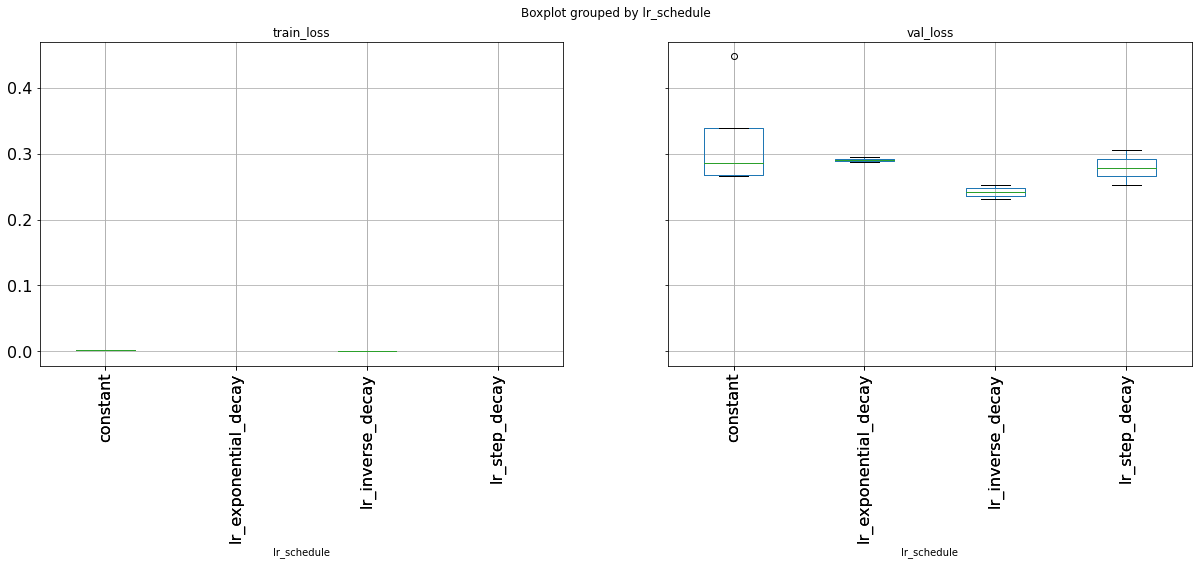

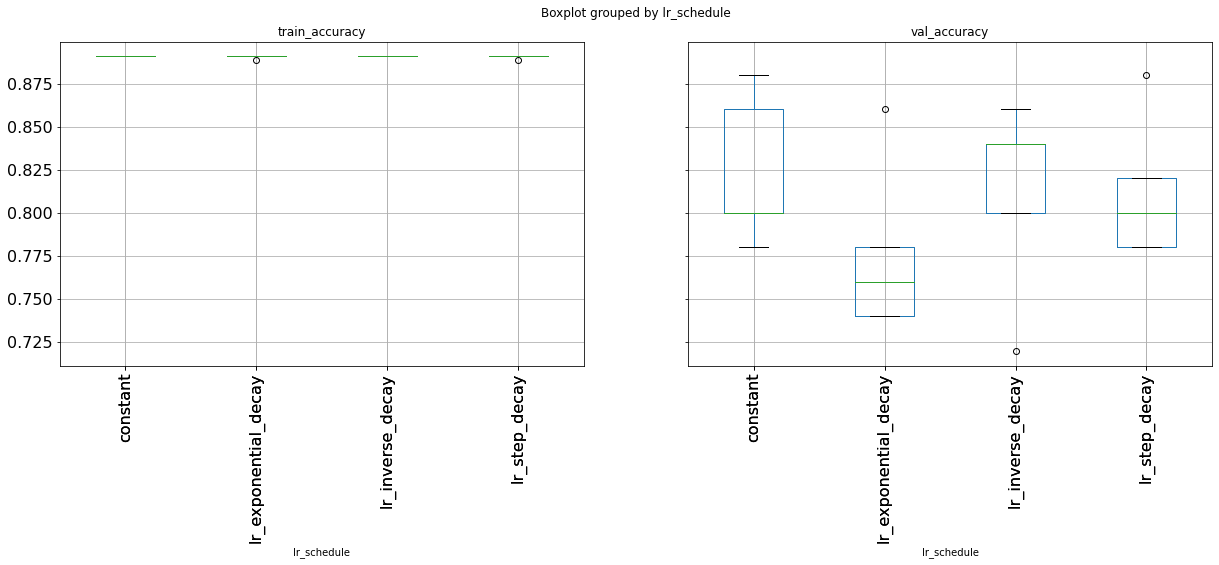

In [ ]:
import pandas as pd

results = pd.DataFrame(columns=['lr_schedule', 'repetition', 'train_loss', 'val_loss', 'train_accuracy', 'val_accuracy'])

for lr_schedule in (None, lr_step_decay, lr_inverse_decay, lr_exponential_decay):
  print('Learning rate schedule:', lr_schedule.__name__ if lr_schedule else 'constant')
  for repetition in range(5):
    print('run', repetition)
    my_NN = DeepNeuralNet_Swish(X_train.shape,
                  NUM_CLASSES,
                  batch_size=BATCHSIZE,
                  init_lr=LEARNING_RATE,
                  lr_scheduler=lr_schedule,
                  verbose=False
                  )
    history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)
    run_results = [lr_schedule.__name__ if lr_schedule else 'constant', 
                   repetition,
                   history['loss'][-1],
                   history['val_loss'][-1],
                   history['train_acc'][-1],
                   history['val_acc'][-1],
                   ]
    results.loc[len(results)] = run_results

axes = results.boxplot(column=['train_loss', 'val_loss'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()

axes = results.boxplot(column=['train_accuracy', 'val_accuracy'], 
                by='lr_schedule',
                figsize=(20,6), 
                fontsize=16,
                rot=90,
                )
plt.show()